## Introdução

Neste notebook, vamos criar uma rede neural capaz de classificar objetos celestes em três categorias:

- Galáxias
- Estrelas
- Quasares

O conjunto de dados utilizado é o Stellar Classification Dataset (SDSS17).  
O objetivo é aplicar conceitos de Deep Learning para resolver um problema de classificação multiclasse.

Durante o processo, também vamos:

- Investigar o impacto de largura e profundidade da rede;
- Analisar overfitting e underfitting ao variar épocas e taxa de aprendizado;
- Explorar técnicas de regularização e otimizadores diferentes.

O framework utilizado será o TensorFlow (Keras).


In [3]:
!pip install -q tensorflow pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers

## Carregamento e pré-processamento dos dados

Antes de treinar o modelo, precisamos preparar os dados.  
Isso inclui:

- Carregar o CSV com os dados do SDSS17;
- Remover colunas irrelevantes (como IDs);
- Codificar as classes como números;
- Normalizar os atributos numéricos;
- Dividir os dados entre treino e teste.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving star_classification.csv to star_classification.csv


In [7]:
df = pd.read_csv('star_classification.csv')
df = df.drop(columns=['obj_ID', 'spec_obj_ID', 'fiber_ID', 'run_ID'])
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
X = df.drop(columns=['class'])
y = df['class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Definindo a arquitetura da rede neural

Agora vamos criar uma função que gera uma rede neural com os parâmetros:

- Largura: quantos neurônios por camada oculta;
- Profundidade: quantas camadas ocultas usar;
- Regularização L2: técnica para reduzir overfitting penalizando pesos grandes;
- Otimizador: algoritmo para atualizar os pesos da rede.


In [8]:
def build_model(input_dim, width=64, depth=2, lr=0.001, l2=0.0, optimizer_name='adam'):
    model = models.Sequential()
    for _ in range(depth):
        model.add(layers.Dense(width, activation='relu',
                               kernel_regularizer=regularizers.l2(l2),
                               input_dim=input_dim))
        input_dim = width
    model.add(layers.Dense(3, activation='softmax'))

    optimizer_dict = {
        'adam': optimizers.Adam(learning_rate=lr),
        'sgd': optimizers.SGD(learning_rate=lr),
        'rmsprop': optimizers.RMSprop(learning_rate=lr)
    }

    model.compile(optimizer=optimizer_dict[optimizer_name],
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


## Treinamento do modelo e visualização dos resultados

Vamos criar uma função que:

- Treina a rede neural com base nos parâmetros fornecidos;
- Gera gráficos de acurácia e perda durante as épocas;
- Ajuda a diagnosticar overfitting e underfitting.


In [9]:
def train_and_plot(width, depth, epochs=50, lr=0.001, l2=0.0, optimizer='adam'):
    model = build_model(X_train.shape[1], width, depth, lr, l2, optimizer)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, verbose=0)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f"width={width}, depth={depth}, lr={lr}, l2={l2}, opt={optimizer}")
    plt.show()


## Testes: variando largura, profundidade, learning rate, regularização e otimizadores

Agora vamos realizar experimentos práticos:

1. Largura – mais neurônios por camada permitem capturar padrões mais complexos;
2. Profundidade – redes mais profundas têm maior capacidade de abstração;
3. Épocas e Learning Rate – permitem ajustar a velocidade e duração do aprendizado;
4. Regularização – combate o overfitting penalizando pesos exagerados;
5. Otimizadores – algoritmos diferentes podem melhorar a convergência.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


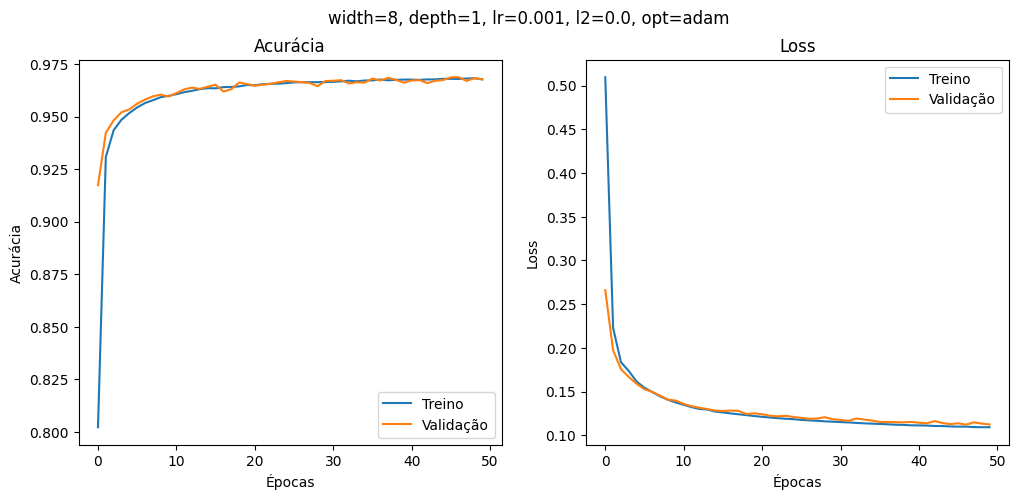

In [ ]:
train_and_plot(width=8, depth=1, epochs=50, lr=0.001)
train_and_plot(width=64, depth=1, epochs=50, lr=0.001)
train_and_plot(width=64, depth=4, epochs=50, lr=0.001)
train_and_plot(width=64, depth=2, epochs=50, lr=0.01)
train_and_plot(width=64, depth=2, epochs=50, lr=0.001, l2=0.01)
train_and_plot(width=64, depth=2, epochs=50, lr=0.01, optimizer='sgd')
